# Práctica 3 - Localización EKF y Mapeo

**Profesor**: Prof. Dr. Ignacio Mas

**Fecha límite de entrega**: 13/10/2024, 23:59hs

---

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

from probotics import KalmanFilter
from probotics import GridMapping1D

%load_ext autoreload
%autoreload 2

## 1. Filtro de Kalman Extendido

En este ejercicio se implementará un filtro de Kalman Extendido (EKF) basándose en una estructura de código provista por la cátedra.

### 1.1 Notas preliminares

La estructura provista contiene los distintos componentes del filtro EKF, para que el esfuerzo del desarrollo sea en los detalles de la implementación del filtro propiamente dicho. El módulo `probotics` contiene un directorio `localization` con la implementación de los diferentes filtros vistos en el curso. El archivo `kalman.py` contiene la clase `KalmanFilter` que es la base para la implementación del filtro de Kalman Extendido. Dicha clase contine la siguiente estructura:
```Python

class KalmanFilter:
    def __init__(self, mu0, sigma0, world_data_path, odometry_noise, measurement_noise, robot_radius=1):
        # Constructor de la instancia
        # ...

    def update(self, odometry: dict, sensor: dict):
        # Paso de predicción
        mu_hat, sigma_hat = self.prediction_step(odometry)

        # Paso de corrección
        mu, sigma = self.correction_step(mu_hat, sigma_hat, sensor)
        self.robot.current_pose = mu

        # Guardado de los parámetros
        self.mu = mu
        self.sigma = sigma

    def prediction_step(self, odometry: dict):
        # Implementación del paso de predicción
        # ...

    def correction_step(self, mu_hat: np.ndarray, sigma_hat: np.ndarray, sensor: dict):
        # Implementación del paso de corrección
        # ...
```
Para este ejercicio se debe implementar los métodos `prediction_step` y `correction_step` de la clase `KalmanFilter` para que el filtro de Kalman Extendido funcione correctamente. Para ello se va a asumir que el ruido del modelo de movimiento está definido por 

$$
Q_t = \begin{bmatrix} 
0.2 & 0 & 0 \\
0 & 0.2 & 0 \\
0 & 0 & 0.02 
\end{bmatrix}
$$

y que el ruido de medición está caracterizado por la matriz diagonal cuadrada $R_t$:

$$
R_t = \begin{bmatrix} 
0.5 & 0 & \ldots & 0 \\
0 & 0.5 & \ldots & 0\\
\vdots & \vdots &\ddots & \vdots \\
0 & 0 & \ldots & 0.5
\end{bmatrix}
\in \mathbb{R}^{size(z_t)\,\times\, size(z_t)}
$$

In [2]:
# Matrices del modelo
Q = np.diag([0.2, 0.2, 0.02])
measurement_noise = 0.5 # R_t = I * measurement_noise

Utilizar los siguientes datos de juguete para testear el funcionamiento de las funciones `prediction_step` y `correction_step`.

In [3]:
# Data de prueba para testear el código
odom = {"r1": 0.1, "t": 2.0, "r2": 0.0}
sensor = {"id": [3, 2], "range": [5.0, 2.1], "bearing": [0.1, 0.1]}

# Landmarks de prueba
world_data = pd.DataFrame({
    "id": [1, 2, 3],
    "x": [4.0, 2.0, 5.0],
    "y": [0.0, 0.0, 0.0],
}).set_index("id")

# Parámetros iniciales de prueba
mu0 = np.array([1, 2, 3])
sigma0 = np.eye(3) * 0.1

### 1.2. Paso de predicción EKF

Supongamos que tenemos un robot diferencial operando en el plano, por lo que su estado esta definido por $\langle x, y, \theta \rangle$. Su modelo de movimiento esta definido como el Modelo de Odometrı́a visto en clase en el capı́tulo de *modelos de movimiento*.

1. Calcular la matriz jacobiana $G_t$ de la función de movimiento $g$ sin ruido.

**Respuesta**:

Utilizamos el modelo de odometría definido por la función
$$
g(u_t,x_{t-1}) = 
\begin{bmatrix}
x(t-1) + \delta_t(t) \cos(\delta_{r1}(t) + \theta(t-1)) \\
y(t-1) + \delta_t(t) \sin(\delta_{r1}(t) + \theta(t-1)) \\
\theta(t-1) + \delta_{r1}(t) + \delta_{r2}(t)
\end{bmatrix}
$$

Aplicamos el desarrollo de Taylor de esta función para obtener las ecuaciones que definen el paso de predicción del filtro de Kalman extendido:
$$
g(u_t,x_{t-1}) \approx g(u_t,\mu_{t-1}) + \frac{\partial g}{\partial x_{t-1}}\bigg\rvert_{\mu_{t-1}} (x_{t-1} - \mu_{t-1})
$$
con
$$
G_t = \frac{\partial g}{\partial x_{t-1}}\bigg\rvert_{\mu_{t-1}} =
\begin{bmatrix}
\frac{\partial x}{\partial x_{t-1}} & \frac{\partial x}{\partial y_{t-1}} & \frac{\partial x}{\partial \theta_{t-1}} \\
\frac{\partial y}{\partial x_{t-1}} & \frac{\partial y}{\partial y_{t-1}} & \frac{\partial y}{\partial \theta_{t-1}}\\
\frac{\partial \theta}{\partial x_{t-1}} & \frac{\partial \theta}{\partial y_{t-1}} & \frac{\partial \theta}{\partial \theta_{t-1}} \\
\end{bmatrix} = 
\begin{bmatrix}
1 & 0 & -\delta_t(t) \sin(\delta_{r1}(t) + \mu_\theta(t-1)) \\
0 & 1 & \delta_t(t) \cos(\delta_{r1}(t) + \mu_\theta(t-1)) \\
0 & 0 & 1
\end{bmatrix}
$$
el jacobiano de la función $g(u_t,x_{t-1})$ y 
$$
\mu_{t-1}=\begin{bmatrix} \mu_x(t-1) & \mu_y(t-1) & \mu_\theta(t-1) \end{bmatrix}^T
$$. 

Con esto, el paso de predicción del filtro de Kalman extendido resulta:
$$
\begin{align*}
\hat{\mu}_t &= g(u_t,\mu_{t-1}) \\[.5em]
\hat{\Sigma}_t &= G_t \Sigma_{t-1} G_t^T + Q_t 
\end{align*}
$$

2. Implementar el paso de predicción del filtro EKF en la función `prediction_step` usando el jacobiano $G_t$ calculado en el punto anterior.

In [4]:
# Init Filter and run prediction step
kf = KalmanFilter(mu0, sigma0, world_data=world_data, odometry_noise=Q, measurement_noise=measurement_noise)
mu_hat, sigma_hat = kf.prediction_step(odom)

# Test prediction step
assert np.isclose(mu_hat, np.array([-0.9982703, 2.08316132, 3.1])).all()
assert np.isclose(sigma_hat, np.array([
    [ 0.30069158,  0.01661788, -0.00831613],
    [ 0.01661788,  0.69930842, -0.19982703],
    [-0.00831613, -0.19982703,  0.12      ]
])).all()

print("Prediction step test passed!")

Prediction step test passed!


### 1.3. Paso de corrección EKF

1. Calcular la matriz jacobiana $H_t$ de la función de medición $h$ sin ruido de un sensor que sólo mide distancia (range).

**Respuesta**: 

La medición en este caso está dada por la distancia a los *landmarks*, con lo cual, en cada paso el vector $z_t$ tendrá la dimensión igual a la cantidad de *landmarks* medidos, y cada una de las componentes del vector $h(x_t)$ va a estar dada por:
$$
h_{t\,i} = \sqrt{(x(t)-l_{x\,i})^2 + (y(t)-l_{y\,i})^2}
$$
donde $l_{x\,i}$ y $l_{y\,i}$ son, respectivamente, las coordenadas en $x$ y en $y$ del landmark $i$. Ahora, calculamos el jacobiano $H_t$ de esta función respecto de las variables $x(t)$ y $y(t)$:
$$
\begin{align*}
H_t &= \frac{\partial h_t}{\partial x_{t}}\bigg\rvert_{\hat{\mu}_{t}} = \begin{bmatrix} 
\frac{\partial h_{t\,1}}{\partial x(t)} & \frac{\partial h_{t\,1}}{\partial y(t)} & \frac{\partial h_{t\,1}}{\partial \theta(t)} \\
\frac{\partial h_{t\,2}}{\partial x(t)} & \frac{\partial h_{t\,2}}{\partial y(t)} & \frac{\partial h_{t\,2}}{\partial \theta(t)}\\
\vdots & \vdots & \vdots \\
\frac{\partial h_{t\,n}}{\partial x(t)} & \frac{\partial h_{t\,n}}{\partial y(t)} & \frac{\partial h_{t\,n}}{\partial \theta(t)}\\
\end{bmatrix}_{\hat{\mu}_{t}} 
= \begin{bmatrix} 
\frac{\hat{\mu_x}(t)-l_{x\,1}}{\sqrt{(\hat{\mu_x}(t)-l_{x\,1})^2 + (\hat{\mu_y}(t)-l_{y\,1})^2}} & \frac{\hat{\mu_y}(t)-l_{y\,1}}{\sqrt{(\hat{\mu_x}(t)-l_{x\,1})^2 + (\hat{\mu_y}(t)-l_{y\,1})^2}} & 0\\
\vdots & \vdots & \vdots\\
\frac{\hat{\mu_x}(t)-l_{x\,n}}{\sqrt{(\hat{\mu_x}(t)-l_{x\,n})^2 + (\hat{\mu_y}(t)-l_{y\,n})^2}} & \frac{\hat{\mu_y}(t)-l_{y\,n}}{\sqrt{(\hat{\mu_x}(t)-l_{x\,n})^2 + (\hat{\mu_y}(t)-l_{y\,n})^2}} & 0\\
\end{bmatrix}
\end{align*}
$$

De esta manera, el paso de corrección se puede escribir como:
$$
\begin{align*}
\hat{\mu}_t &= \begin{bmatrix} \hat{\mu}_x(t) & \hat{\mu}_y(t) & \hat{\mu}_\theta(t) \end{bmatrix}^T \\
K_t &= \hat{\Sigma}_t H_t^T (H_t \hat{\Sigma}_t H_t^T + R_t)^{-1} \\[.5em]
\mu_t &= \hat{\mu}_t + K_t(z_t - h(\hat{\mu_t})) \\[.5em]
\Sigma_t &= (I - K_t H_t)\hat{\Sigma}_t 
\end{align*}
$$

2. Implementar el paso de corrección del filtro EKF en la función `correction_step` usando el jacobiano $H_t$.

In [5]:
mu, sigma = kf.correction_step(mu_hat, sigma_hat, sensor)

# Test correction step
assert np.isclose(mu, np.array([-0.39306115,  1.35858764,  3.29965201])).all()
assert np.isclose(sigma, np.array([
    [ 0.18871925,  0.13434928, -0.04059433],
    [ 0.13434928,  0.53075435, -0.15310905],
    [-0.04059433, -0.15310905,  0.10704702]
])).all()

print("Correction step test passed!")

Correction step test passed!


### 1.4 Visualización

Luego de implementar los pasos de predicción y corrección es posible visualizar el comportamiento del filtro en datos reales.

<IPython.core.display.Javascript object>


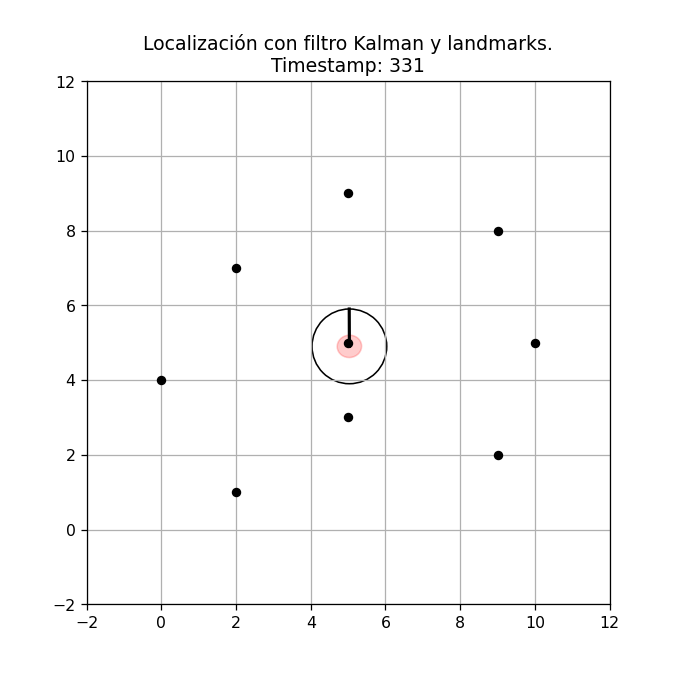

In [11]:
from probotics.src.utils import read_sensor_data, plot_ellipse

def visualize_ekf(mu0, sigma0, sensor_data, world_data, Q=np.eye(3), sensor_noise=0.1, robot_radius=1):

    # Initialize Kalman Filter
    kf = KalmanFilter(mu0, sigma0, world_data, Q, sensor_noise, robot_radius)
    mu, sigma = kf.mu, kf.sigma

    # Read data
    sensor_data = read_sensor_data(sensor_data)

    # Init plot
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    plt.ion()
    fig.show()
    
    # Iterate through data
    for t in range(len(sensor_data)):

        # Update plot
        ax.cla()
        ax.set_xlim(-2, 12)
        ax.set_ylim(-2, 12)
        ax.set_aspect('equal')
        ax.grid(True)
        ax.set_title("Localización con filtro Kalman y landmarks.\nTimestamp: " + str(t))
        ax.plot(kf.sensor.landmarks['x'], kf.sensor.landmarks['y'], 'ko', markersize=5)
        plot_ellipse(mu[:2], sigma[:2, :2], ax, color='r')
        kf.robot.plot(ax, color='k')
        fig.canvas.draw()
        
        # Update Kalman Filter
        kf.update(sensor_data[t]['odom'], sensor_data[t]['sensor'])
        mu, sigma = kf.mu, kf.sigma
        
    # Update plot
    ax.cla()
    ax.set_xlim(-2, 12)
    ax.set_ylim(-2, 12)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title("Localización con filtro Kalman y landmarks.\nTimestamp: " + str(len(sensor_data)))
    ax.plot(kf.sensor.landmarks['x'], kf.sensor.landmarks['y'], 'ko', markersize=5)
    plot_ellipse(mu[:2], sigma[:2, :2], ax, color='r')
    kf.robot.plot(ax, color='k')
    fig.canvas.draw()
        
mu0 = np.zeros(3)
sigma0 = np.eye(3)
sensor_data = "../data/localization/sensor_data.dat"
world_data = "../data/localization/world.dat"
Q = np.diag([0.2, 0.2, 0.02])
sensor_noise = 0.5

visualize_ekf(mu0, sigma0, sensor_data, world_data, Q, sensor_noise)

## 2. Mapeo con poses conocidas

Un robot debe construir un mapa de grilla de ocupación (celdas $c_0$, $\ldots$, $c_n$) de un entorno unidimensional usando una secuencia de mediciones de un sensor de distancia. Asumir el siguiente modelo de sensor: cada celda de la grilla con una distancia menor que la distancia medida se asume ocupada con una probabilidad de $p = 0.3$. Cada celda más allá de la distancia medida se asume ocupada con una probabilidad de $p = 0.6$. Las celdas ubicadas a más de $20\,\mathrm{cm}$ por detrás de la distancia medida no cambian su probabilidad de ocupación.

<p align="center">
  <img src="./img/grilla_unidimensional.png" />
</p>


El mapeo unidimensional está implementado en la clase `GridMapping1D` del módulo `probotics`, que se encuentra en el archivo `grid1d.py`. La clase tiene la siguiente estructura:

```Python
class GridMapping1D:
    def __init__(self, initial_belief, grid_size, grid_interval, backgroud_limit):
        # Constructor de la instancia
        # ...

    def update(self, robot_position, z):
        # Obtiene el nuevo belief a partir de una nueva medición
        logodds = logit(self.belief)
        new_prediction = self.inverse_sensor_model(self.belief, robot_position, z)
        new_loggods = logodds + new_prediction - self.logodds_0
        self.belief = expit(new_loggods)

    @property
    def grid(self):
        return np.arange(0, self.grid_size + 1) * self.grid_interval

    def position_to_cell(self, position):
        """Obtiene la celda correspondiente a la posición"""
        return np.digitize(position, self.grid) - 1

    def inverse_sensor_model(self, belief, robot_position, z):
        # Implementación del modelo inverso del sensor
        # ...
```

1. Implementar la función `inverse_sensor_model` que recibe `belief` (probabilidad de ocupación de cada celda de la grilla), la posición `robot_position` del robot en el mapa y una medición `z` para actualizar el *belief* utilizando el modelo explicado anteriormente. Las mediciones y el *belief a priori* se detallan en la siguiente tabla:

<div align="center">

| | |
|---|:---:|
| Resolución de la grilla | 10cm |
| Logitud del mapa (1-D) | 2m |
| posición del robot | $c_0$ |
| orientación del sensor | mirando hacia $c_n$ (ver figura 2.1) |
| mediciones (en cm) | 101, 82, 91, 112, 99, 151, 96, 85, 99, 105 |
| prob. a priori | 0.5 |
| | |

In [7]:
grid_size = 10
grid_interval = 1
backgroud_limit = 1
initial_belief = np.ones(grid_size + 1) * .5
mapping = GridMapping1D(initial_belief, grid_size, grid_interval, backgroud_limit)
logodds = mapping.inverse_sensor_model(initial_belief, 0, 4)

assert np.isclose(logodds, np.array([-0.84729786, -0.84729786, -0.84729786, -0.84729786, 0, 0, 0, 0, 0, 0, 0])).all()
print("All tests passed!")

All tests passed!


2. Graficar el *belief* para cada medición.

<IPython.core.display.Javascript object>


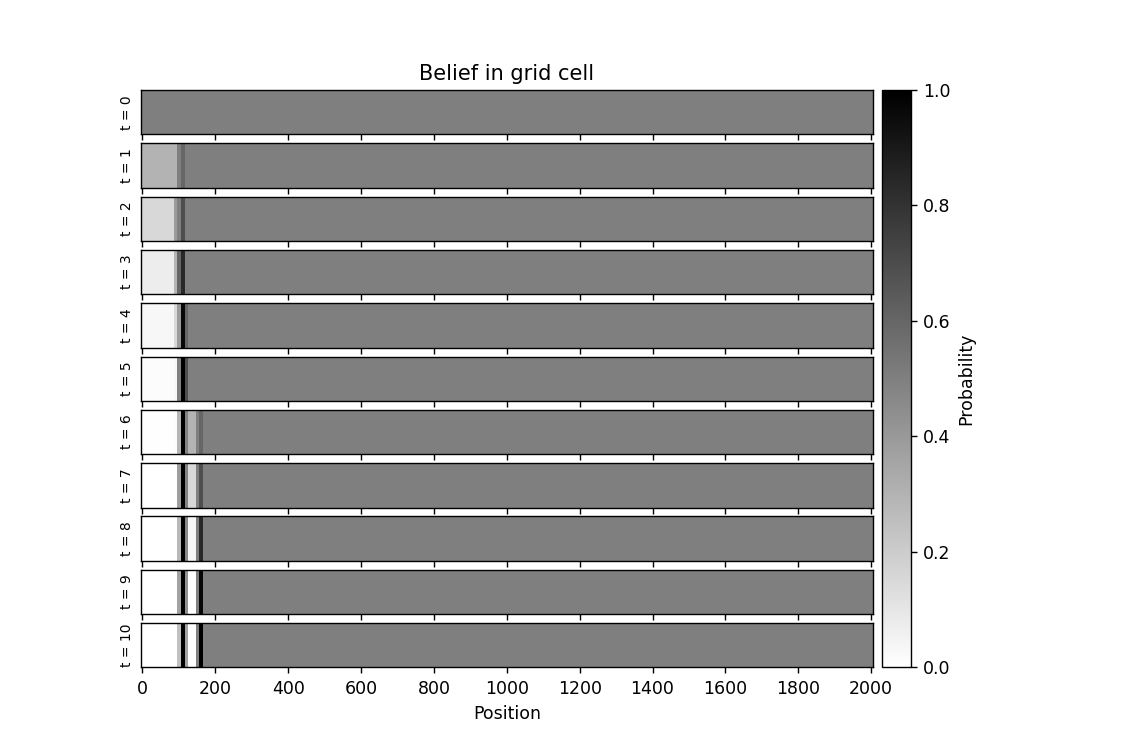

In [8]:
def plot_belief(history, grid):
    fig, ax = plt.subplots(len(history), 1, figsize=(9, 6), sharex=True)
    normalize = Normalize(vmin=0, vmax=1)
    images = []
    for i, belief in enumerate(history):
        images.append(ax[i].imshow(belief.reshape(1,-1), cmap='gray_r', norm=normalize, aspect='auto'))
        ax[i].set_ylabel(f't = {i}', fontsize=8)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
    ax[0].set_title('Belief in grid cell')
    ax[-1].set_xlabel('Position')
    ax[-1].set_xticks(np.arange(0, len(grid) + 1)[::20])
    ax[-1].set_xticklabels(grid[::20])
    fig.colorbar(images[0], ax=ax, orientation='vertical', pad=0.01, label='Probability')


grid_size = 200 # Número de celdas en el mapa
grid_interval = 10 # Intervalo entre celdas (en cm)
backgroud_limit = 20 # Distancia más allá de la cual no cambia la probabilidad de ocupación (en cm)
robot_position = 0 # Posición inicial del robot (en cm)
prior = 0.5

# Instanciamos el mapa
mapping = GridMapping1D(prior, grid_size, grid_interval, backgroud_limit)

# Obtenemos el historial de beliefs con las mediciones
measurements = [101, 82, 91, 112, 99, 151, 96, 85, 99, 105] # Mediciones de distancia (en cm)
history = [mapping.belief]
for z in measurements:
    mapping.update(robot_position, z)
    history.append(mapping.belief)

# Graficamos el mapa
plot_belief(history, mapping.grid)

3. Se decide invertir en un sensor más costoso y se toman nuevamente las mediciones. Ejecutar nuevamente el algoritmo de mapeo con el mismo modelo del punto anterior, pero ahora con las siguientes mediciones:

<div align="center">

| | |
|---|:---:|
| mediciones (en cm) | 101, 99, 97, 102, 99, 100, 96, 104, 99, 105 |
| | |

<IPython.core.display.Javascript object>


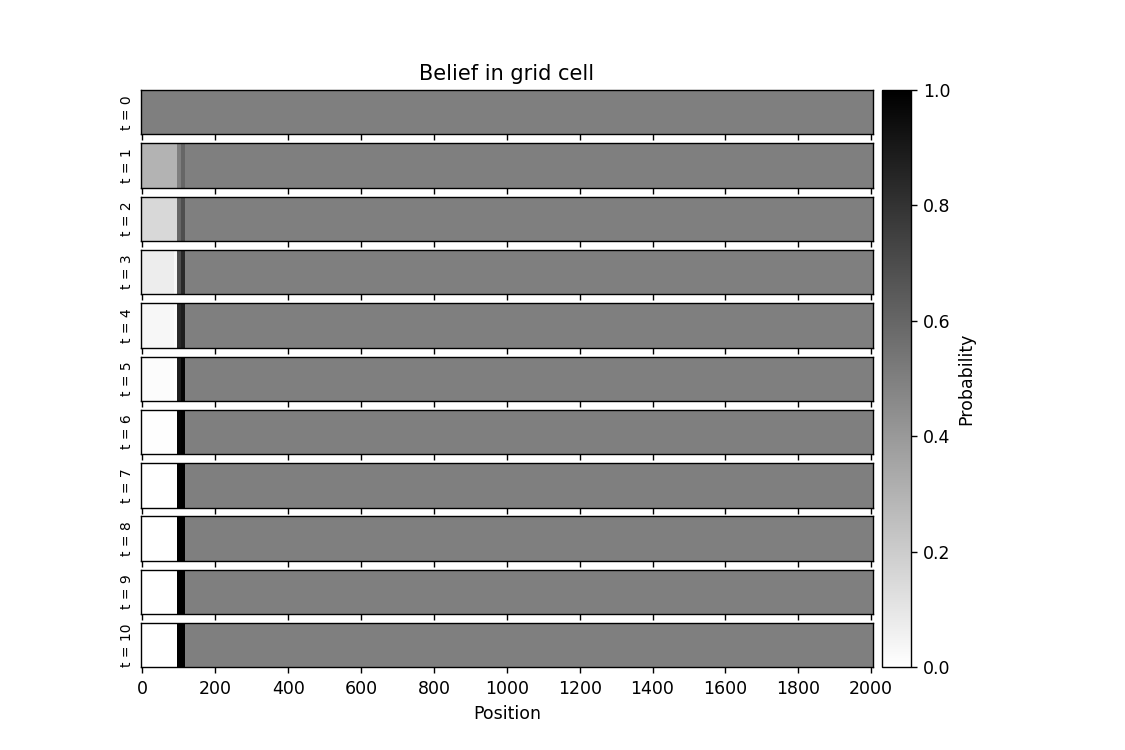

In [9]:
# Instanciamos de nuevo el mapa
mapping = GridMapping1D(prior, grid_size, grid_interval, backgroud_limit)

# Obtenemos el historial de beliefs con las nuevas mediciones
measurements = [101, 99, 97, 102, 99, 100, 96, 104, 99, 105] # Mediciones de distancia (en cm)
history = [mapping.belief]
for z in measurements:
    mapping.update(robot_position, z)
    history.append(mapping.belief)

# Graficamos el mapa
plot_belief(history, mapping.grid)